In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Set the font family to Arial/Helvetica
#conda install -c conda-forge mscorefonts if needed
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib widget

import os
# from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, report_fit

import scipy.stats as st
import statsmodels.tools.numdiff as smnd

In [2]:
# Define the curve function you want to fit 
def curve_function(t, g0, tauD, AmpX, tauX, offset):
    return g0 /(1+t/tauD)*(1+AmpX*np.exp(-t/tauX)) + offset

#create fitting parameters
def create_params(inital_params, vary_): 
    # Create an lmfit Parameters object and set initial guess values
    params = Parameters()
    params.add('g0', value= initial_params[0], min=0.0, max=10, vary=vary_[0])
    params.add('tauD', value= initial_params[1], min=0.0, max=10, vary=vary_[1])
    params.add('AmpX', value= initial_params[2], min=0.0, max=10, vary=vary_[2])
    params.add('tauX', value= initial_params[3], min=0.0, max=5e-6, vary=vary_[3])
    params.add('offset', value= initial_params[4], min=-0.1, max=0.1, vary=vary_[4])
    return params

# Define the fitting function
def curve_fitting_lmfit(params,t):
    g0 = params['g0']
    tauD = params['tauD']
    AmpX = params['AmpX']
    tauX = params['tauX']
    offset = params['offset']
    y_fit = g0 /(1+t/tauD)*(1+AmpX*np.exp(-t/tauX)) + offset
    return y_fit #-y

#define the objective function for fit
def residuals(params,t,y, y_std) :
    if y_std is None: 
        y_std = np.ones(y.shape[0])        
    return (curve_fitting_lmfit(params,t) - y)/y_std

In [3]:
# Define the parent directory containing the subdirectories
parent_directory = os.getcwd()
#'D:/Data/231020/beads-_12_11_12-20_10_2023 CSV'

In [4]:
counter = 0

# Initialize dataframe to store intensities and correlation
df_intensities = pd.DataFrame()
df_correlation = pd.DataFrame()

# Iterate over subdirectories ('repetition1', 'repetition2', etc.)
for subdir in os.listdir(parent_directory):
    subdirectory_path = os.path.join(parent_directory, subdir)
    
    # Check if the subdirectory is a directory
    if os.path.isdir(subdirectory_path):
        for root, dirs, files in os.walk(subdirectory_path):
            for file in files:
                if file == 'Raw Data.csv':
                    file_path = os.path.join(root, file)
                    counter += 1
                    #print(counter)
                    #print(file_path)
                    
                    
                    # Read the CSV file using pandas and find the row where 'Lag Time [s],Correlation Function' appears
                    with open(file_path, 'r') as file:
                        lines = file.readlines()
                        
                    # Initialize variables to store tabular sections
                    first_tabular = None
                    second_tabular = None
                    third_tabular = None

                    # Flags to determine which tabular section we are in
                    in_first_tabular = False
                    in_second_tabular = False
                    in_third_tabular = False

                    for line in lines:
                        line = line.strip()
                        if not line:
                            continue

                        if "Average Count Rate ChA" in line:
                            in_first_tabular = True
                            in_second_tabular = False
                            in_third_tabular = False
                            first_tabular_data = []

                        elif "Count Trace ChA" in line:
                            in_first_tabular = False
                            in_second_tabular = True
                            in_third_tabular = False
                            second_tabular_data = []

                        elif "Lag Time" in line:
                            in_first_tabular = False
                            in_second_tabular = False
                            in_third_tabular = True
                            third_tabular_data = []

                        elif in_first_tabular:
                            first_tabular_data.append(line.split(','))
                        elif in_second_tabular:
                            second_tabular_data.append(line.split(','))
                        elif in_third_tabular:
                            third_tabular_data.append(line.split(','))
                        '''
                    if second_tabular_data : 
                        array = np.array(second_tabular_data).astype(float)
                        
                        if counter == 1 :
                            array2 = array
                       
                        array2 = np.hstack((array2,array))
                        '''

                    
                        # Convert the tabular data into DataFrames
                    if first_tabular_data:
                        first_tabular = pd.DataFrame(first_tabular_data)
                        first_tabular = first_tabular.apply(pd.to_numeric)
                      
                    if second_tabular_data:
                        second_tabular = pd.DataFrame(second_tabular_data)
                        second_tabular = second_tabular.apply(pd.to_numeric)
                        df_intensities = pd.concat([df_intensities, second_tabular], axis = 1)
                         
                    if third_tabular_data:
                        third_tabular = pd.DataFrame(third_tabular_data)
                        third_tabular = third_tabular.apply(pd.to_numeric)
                            
                        if counter == 1: 
                            df_correlation = pd.concat([df_correlation, third_tabular], axis = 1)
                        else :
                            df_correlation = pd.concat([df_correlation, third_tabular.iloc[:,[1]]], axis = 1)
                    
df_intensities = df_intensities.astype('float32')
#df_correlation = df_correlation.astype('float32')
'''
# Print or use the first and second tabular DataFrames as needed
if first_tabular is not None:
    print("First Tabular Section:")
    print(first_tabular)

if second_tabular is not None:
    print("\nSecond Tabular Section:")
    print(second_tabular)

if third_tabular is not None:
    print("\nThird Tabular Section:")
    print(third_tabular)

'''
    
del(first_tabular, first_tabular_data, second_tabular, second_tabular_data, third_tabular, third_tabular_data, 
    in_first_tabular, in_second_tabular, in_third_tabular, file, files, line, root, subdir, dirs, file_path,
    subdirectory_path, lines)

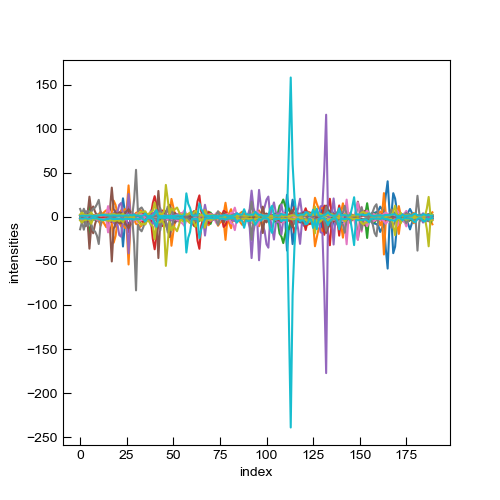

In [5]:
#Plot Intensities
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(df_intensities.drop(columns=1));
ax.plot(-df_intensities.drop(columns=0));
ax.tick_params(axis='both', direction='in', length=6, color='k')
ax.set(xlabel=r'index', ylabel='intensities');

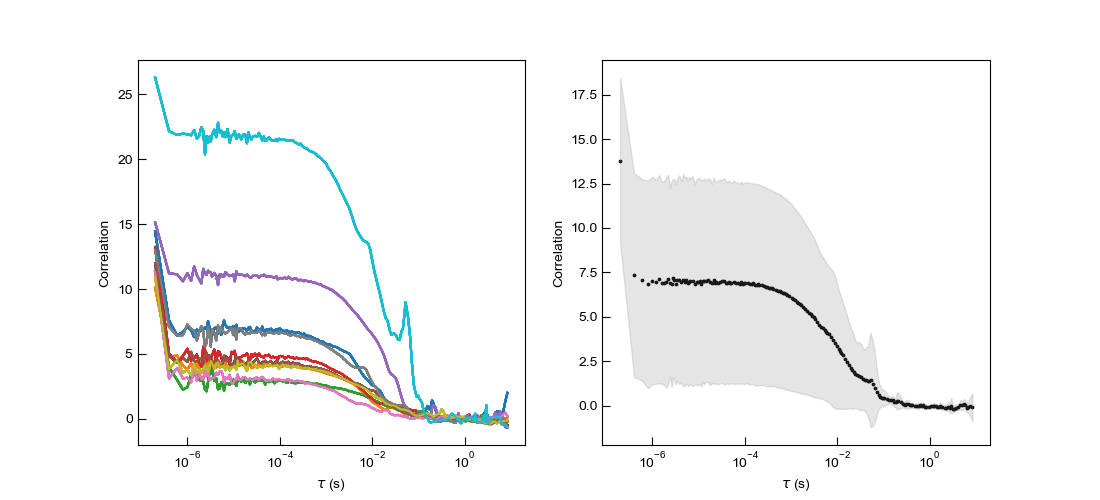

In [6]:
#Make a plot and returns x (tau), correlation_mean and correlation_std
def MyPlot(dataframe):
    plt.close('all')
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    df = dataframe
    # Plot columns 1 to 10 against column 0
    x = df.iloc[0:, 0]  # Column 0
    y = df.iloc[0:, 1:(df.shape[1])]  # Columns 1 to end

    y_mean = y.mean(axis = 1)
    y_std = y.std(axis = 1)
    

    for column in y.columns:
        ax[0].semilogx(x, y[column], label=column)

    ax[0].set(xlabel=r'$\tau$ (s)', ylabel='Correlation')
    ax[0].tick_params(axis='both', direction='in', length=6, color='k')

 
    ax[1].scatter(x, y_mean, color='k', s=3)
    ax[1].set_xscale('log')
    ax[1].set(xlabel=r'$\tau$ (s)', ylabel='Correlation')
    ax[1].fill_between(x, y_mean-y_std, y_mean + y_std, alpha=0.2, color='0.5')
    ax[1].tick_params(axis='both', direction='in', length=6, color='k')

    

    return x, y_mean, y_std
    
x, y_mean, y_std = MyPlot(df_correlation)

In [7]:
# Crop data to what you want: give max time
min_t = 1e-6 #min time in sec.
max_t = 1 # max time in sec.

# define or finds the index of the tau column (uncomment what you want)
# x_col_index = 0 # 
x_col_index = df_correlation.columns.get_loc(0)
min_index = min(range(len(df_correlation.iloc[:, x_col_index])), key=lambda i: abs(df_correlation.iloc[:, x_col_index][i]-min_t))
max_index = min(range(len(df_correlation.iloc[:, x_col_index])), key=lambda i: abs(df_correlation.iloc[:, x_col_index][i]-max_t))

print(min_index)
print(max_index)

4
162


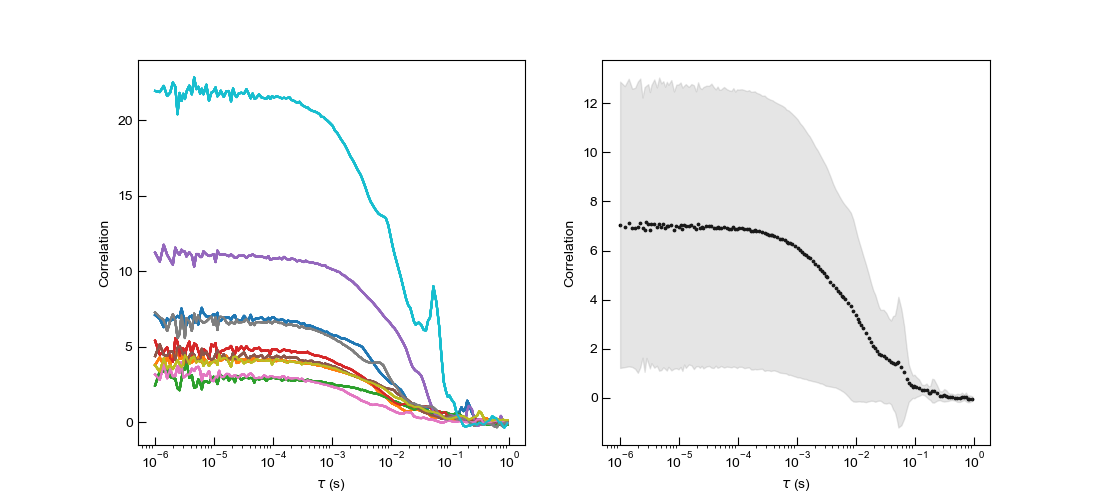

In [8]:
#Make a plot and returns x (tau), correlation_mean and correlation_std
def MyPlot(dataframe):
    plt.close('all')
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    df = dataframe
    # Plot columns 1 to 10 against column 0
    x = df.iloc[min_index:max_index, 0]  # Column 0
    y = df.iloc[min_index:max_index, 1:(df.shape[1])]  # Columns 1 to end

    y_mean = y.mean(axis = 1)
    y_std = y.std(axis = 1)
    

    for column in y.columns:
        ax[0].semilogx(x, y[column], label=column)

    ax[0].set(xlabel=r'$\tau$ (s)', ylabel='Correlation')
    ax[0].tick_params(axis='both', direction='in', length=6, color='k')

 
    ax[1].scatter(x, y_mean, color='k', s=3)
    ax[1].set_xscale('log')
    ax[1].set(xlabel=r'$\tau$ (s)', ylabel='Correlation')
    ax[1].fill_between(x, y_mean-y_std, y_mean + y_std, alpha=0.2, color='0.5')
    ax[1].tick_params(axis='both', direction='in', length=6, color='k')

    
    del(y)
    return x, y_mean, y_std
    
x, y_mean, y_std = MyPlot(df_correlation)

In [9]:
'''Analyse_FCS.pxpinitial_params = (0.5, 44e-6, 0.8, 1.1e-6)


popt, pcov = curve_fit(curve_function, x, y_mean, p0 = initial_params, sigma = y_std, absolute_sigma=True)
print(popt)

plt.plot(x, curve_function(x, *popt), 'r-', linewidth =1 )
plt.show()
''';

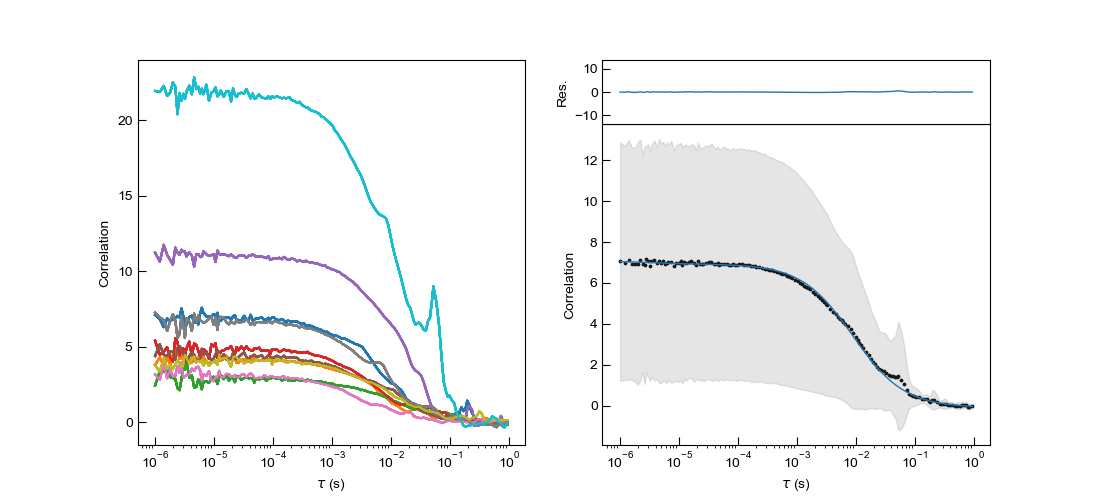

name,value,standard error,relative error,initial value,min,max,vary
g0,7.03166493,0.06162569,(0.88%),0.3,0.00000000,10.0000000,True
tauD,0.00885926,1.9636e-04,(2.22%),0.01,0.00000000,10.0000000,True
AmpX,0.01881312,0.04547077,(241.70%),0.1,0.00000000,10.0000000,True
tauX,5.0000e-06,2.0771e-05,(415.42%),1e-06,0.00000000,5.0000e-06,True
offset,-0.10000000,0.00399227,(3.99%),0,-0.10000000,0.10000000,True


In [10]:
#  g0, tauD, AmpX, tauX, offset
initial_params = (0.3, 0.01, 0.1, 1.e-6, 0)
vary = (True, True, True, True, True)

params = create_params(initial_params, vary)

x, y_mean, y_std = MyPlot(df_correlation)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(residuals, params, args=(x,y_mean,y_std,), method='least_squares')

plt.plot(x, curve_fitting_lmfit(fitted_params.params, x), '-', linewidth = 1 )
#plt.show()

ax = plt.gca()
ax.set_xscale('log')
ylims = ax.get_ylim()
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size = "20%", pad=0)
# ax.figure.add_axes(ax2)

#plt.figure(figsize=(5,5))
plt.semilogx(x, y_mean - curve_fitting_lmfit(fitted_params.params, x), '-', linewidth =1 )
plt.ylim([(-ylims[1]),(ylims[1])])
ax = plt.gca()
ax.tick_params(axis='both', direction='in', length=6, color='k')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set(ylabel='Res.')
plt.show()

# Getting the fitted values
fitted_params.params

name,value,standard error,relative error,initial value,min,max,vary
g0,4.29244416,0.01369229,(0.32%),0.5,0.00000000,10.0000000,True
tauD,0.00683724,8.8429e-05,(1.29%),4.4,0.00000000,10.0000000,True
AmpX,0.00000000,0.00000000,,0,0.00000000,10.0000000,False
tauX,1.1000e-06,0.00000000,(0.00%),1.1e-06,0.00000000,5.0000e-06,False
offset,0.02534262,0.00734344,(28.98%),0,-0.10000000,0.10000000,True


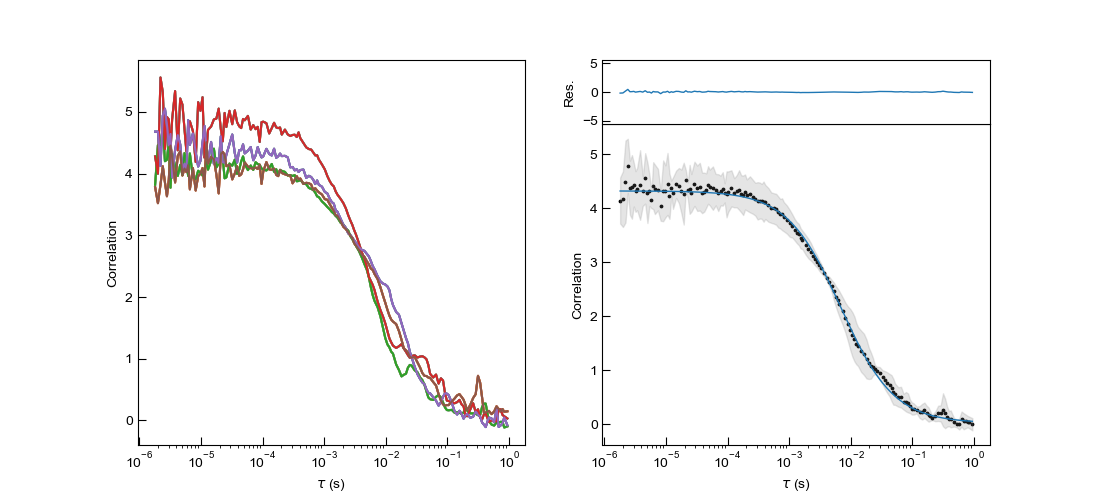

In [11]:
# Define the x value at which you want to check the threshold
x_to_check = 1.0e-4  # Replace with your desired x value

# Define the threshold values
lower_threshold = 3  # Replace with your desired y value
upper_threshold = 5  # Replace with your desired y value

initial_params = (0.5, 44e-1, 0, 1.1e-6,0)
vary = (True, True, False, False, True)

#enter initial guess for fluorescein
#initial_params = (0.5, 44e-6, 0.0, 1.1e-6)
#vary = (True, True, False, False)

# define or finds the index of the tau column (uncomment what you want)
# x_col_index = 0 # 
x_col_index = df_correlation.columns.get_loc(0)

# Find the location of x data matching desired value
#my_loc = int(df_correlation.index[(df_correlation.iloc[:, x_col_index] == x_to_check)  == True][0])
my_loc = min(range(len(df_correlation.iloc[:max_index, x_col_index])), key=lambda i: abs(df_correlation.iloc[0:max_index, x_col_index][i]-x_to_check))
#print(my_loc)

#get the indices of columns where df_correlation is lower than threshold
list = np.where((df_correlation.drop(columns=0).iloc[my_loc, 0:] > lower_threshold) & (df_correlation.drop(columns=0).iloc[my_loc, 0:] < upper_threshold))[0]
# list = np.append(x_col_index,list)

#make a crop list correlation curves according to list. 
df_correlation_crop = df_correlation.drop(columns=0).iloc[min_index:max_index, list]

# put the tau value as first column
df_correlation_crop = pd.concat([df_correlation.iloc[min_index:max_index, x_col_index], df_correlation_crop], axis = 1)

#plot data
x, y_mean, y_std = MyPlot(df_correlation_crop)

#create params
params = create_params(initial_params, vary)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(residuals, params, args=(x,y_mean,y_std,), method='least_squares')

#Plot the function with optimal paramterers
plt.plot(x, curve_fitting_lmfit(fitted_params.params, x), '-', linewidth = 1 )
#plt.show()

'''  Old Sytle with optimize
popt, pcov = curve_fit(curve_function, x, y_mean, p0 = initial_params, sigma = y_std, absolute_sigma=True)
print(popt)
np.diag(pcov)**0.5
oplt.plot(x, curve_function(x, *popt), 'r-', linewidth =1 )
plt.show()
''';

ax = plt.gca()
ylims = ax.get_ylim()
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size = "20%", pad=0)
# ax.figure.add_axes(ax2)

#plt.figure(figsize=(5,5))
#plt.semilogx(x, y_mean - curve_function(x, *popt), 'r-', linewidth =1 )

plt.semilogx(x, y_mean - curve_fitting_lmfit(fitted_params.params, x), '-', linewidth =1 )
plt.ylim([-ylims[1], ylims[1]])
ax = plt.gca()
ax.tick_params(axis='both', direction='in', length=6)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set(ylabel='Res.')

'''
# Further customize the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)    
#    tick.label1.set_rotation('vertical')
''';


# Getting the fitted values
fitted_params.params

#plt.savefig('Beads405.png')


# Getting the fitted values
fitted_params.params